In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)

### Load dataset

Each Image size = 150X150 pixels

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/happy-or-sad',
    labels = 'inferred',
    label_mode = 'binary',
    image_size=(150,150),
    validation_split=0.2, ###If `subset` is set, `validation_split` must be set, and inversely
    subset = 'training', ###If `subset` is set, `validation_split` must be set, and inversely
    #shuffle=False,  ###To get same results
    seed = 22
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = 'Datasets/happy-or-sad',
    labels = 'inferred',
    label_mode = 'binary',
    image_size=(150,150),
    validation_split=0.2, ###If `subset` is set, `validation_split` must be set, and inversely
    subset = 'validation', ###If `subset` is set, `validation_split` must be set, and inversely
    #shuffle=False, ###To get same results
    seed = 22
)
print(train_ds,val_ds)

Found 80 files belonging to 2 classes.
Using 64 files for training.
Found 80 files belonging to 2 classes.
Using 16 files for validation.
<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))> <BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


2022-10-11 16:09:02.282308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### EDA

(16, 150, 150, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


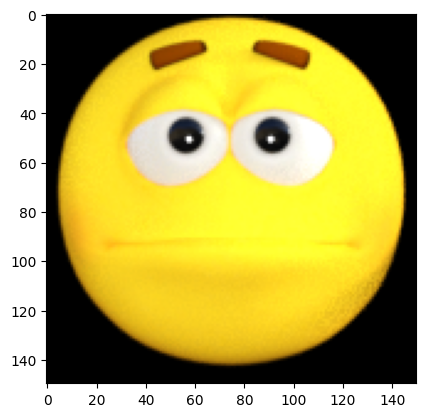

In [3]:
##### Training Set or/and Validation Set

for x,y in val_ds:
    print(x.shape,type(x))
plt.imshow(x.numpy()[0].astype('uint8'))  #Float values
plt.show()

### Feature scaling (Normalization) => Preprocessing layer

In [4]:
# PPL - Option 1 : Part of model
#rescale_layer = tf.keras.layers.Rescaling(scale=1./255,input_shape=(300,300,3))

# PPL Option 2 : Apply to dataset
rescale_layer = tf.keras.layers.Rescaling(scale=1./255)
train_ds = train_ds.map(lambda x,y : (rescale_layer(x),y))
val_ds = val_ds.map(lambda x,y : (rescale_layer(x),y))

### Build MODEL

In [5]:
#callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3,verbose=1)
#callback_cp = tf.keras.callbacks.ModelCheckpoint(
#    filepath = 'Models/C1W4HorseHumans/hh_model', #_{epoch}',
#    monitor = 'val_accuracy',save_best_only = True,save_weights_only = True,verbose=1)
class AccCheck(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy'] >= 0.999:
            print("Reached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

hs_model = tf.keras.models.Sequential([
    #rescale_layer,
    tf.keras.layers.Conv2D(filters=16,kernel_size=3,activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [6]:
hs_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [7]:
hs_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [8]:
hs_model.fit(train_ds,
             validation_data = val_ds,
             epochs = 20,
             callbacks = [AccCheck()])

Epoch 1/20
2/2 [==============================] - 2s 596ms/step - loss: 3.5021 - accuracy: 0.4844 - val_loss: 0.7614 - val_accuracy: 0.5625
Epoch 2/20
2/2 [==============================] - 1s 438ms/step - loss: 0.9962 - accuracy: 0.5156 - val_loss: 1.2362 - val_accuracy: 0.4375
Epoch 3/20
2/2 [==============================] - 1s 449ms/step - loss: 0.9927 - accuracy: 0.5156 - val_loss: 0.8181 - val_accuracy: 0.4375
Epoch 4/20
2/2 [==============================] - 1s 459ms/step - loss: 0.7220 - accuracy: 0.5156 - val_loss: 0.6873 - val_accuracy: 0.4375
Epoch 5/20
2/2 [==============================] - 1s 404ms/step - loss: 0.6787 - accuracy: 0.4844 - val_loss: 0.6643 - val_accuracy: 0.5625
Epoch 6/20
2/2 [==============================] - 1s 423ms/step - loss: 0.6713 - accuracy: 0.4844 - val_loss: 0.6537 - val_accuracy: 0.5625
Epoch 7/20
2/2 [==============================] - 1s 422ms/step - loss: 0.6575 - accuracy: 0.5781 - val_loss: 0.6368 - val_accuracy: 0.7500
Epoch 8/20
2/2 [====